In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_autoenc import SideInformationAutoEncoder

from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


from dsin.train_utils.visibilty_utils.logger_cb_utils import setup_file_logger
from dsin.train_utils.visibilty_utils.pbar_cb_utils import (AverageMetric,
                                            ParameterMetricCallback,
                                            ProgressBarAttibuteVisualizer,
                                            ParameterRunningAverageMetricCallback,
                                            BitEntropy
                                           )
from dsin.train_utils.save_utils import FileNameGenerator

In [3]:
bpp = 0.3
H_target = 2* bpp
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [4]:
logger = setup_file_logger()

In [5]:
config.use_si_flag = SiNetChannelIn.WithSideInformation

#  LOAD BASE-AE

In [6]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 #0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_stereo_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_stereo_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)

batchsize = 1

tfms =  get_transforms(do_flip=True,
                       flip_vert=False,
                       max_rotate=False,
                       max_zoom=0,
                       max_lighting=False,
                       max_warp=False)

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 336), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(baseline_autoencoder,SiNetChannelIn.NoSideInformation,use_feat_loss=False,target_bit_cost = H_target),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])
# learn.load('200815MAE-l2reg-baseline-1')
# learn.load('2020-08-28try2-MAE-l2reg-baseline-bpp0p10-9')
learn.load('2020-08-29try2-MAE-l2reg-baseline-bpp0p30-8')


Learner(data=ImageDataBunch;

Train: LabelList (1576 items)
x: SideinformationImageImageList
ImageSiTuple tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.6465, 0.5606, 0.4442],
         [1.0000, 1.0000, 1.0000,  ..., 0.8471, 0.6217, 0.3216],
         [1.0000, 1.0000, 1.0000,  ..., 0.4640, 0.3560, 0.2957],
         ...,
         [0.1550, 0.1939, 0.1864,  ..., 0.1565, 0.1676, 0.1823],
         [0.1568, 0.1858, 0.1860,  ..., 0.1578, 0.1650, 0.1670],
         [0.1603, 0.1834, 0.1804,  ..., 0.1589, 0.1608, 0.1647]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.6385, 0.4861, 0.3774],
         [1.0000, 1.0000, 1.0000,  ..., 0.7271, 0.5477, 0.2751],
         [1.0000, 1.0000, 1.0000,  ..., 0.6805, 0.4184, 0.2245],
         ...,
         [0.1924, 0.2211, 0.2177,  ..., 0.1893, 0.1998, 0.1952],
         [0.1898, 0.2229, 0.2052,  ..., 0.1811, 0.2007, 0.1996],
         [0.1986, 0.2157, 0.2199,  ..., 0.1912, 0.2059, 0.1923]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.2690, 0.4330, 0.2803],
         [1.0000,

## Freeze Base AE before training first time with SI-AE

In [7]:
learn.freeze_to(-1)

# Create  SI-AE

In [8]:
si_autoencoder = SideInformationAutoEncoder(base_line_auto_enc = learn.model)


learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(si_autoencoder,SiNetChannelIn.WithSideInformation,use_feat_loss=False,target_bit_cost = H_target), #True
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [9]:
model_fname =FileNameGenerator.create_fname(f'MAE-l2reg-si-nofeat-bpp0p{bpp*100:.0f}')
lrs = [1e-4] *3 + [1e-5]  * 2
model_fname

'2020-08-29MAE-l2reg-si-nofeat-bpp0p30'

In [10]:
config.si_loss_weight_alpha = 0.7
learn.model.use_side_infomation = SiNetChannelIn.WithSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.WithSideInformation

offset = 0
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,48.381161,135.562851,1.460780,06:35


iter 0: bpp = 0.027 imp-mean-var(0.06 0.05) total loss92.3  l2reg_loss=13.6autoencoder_loss_value=25.1si_loss=101.0feat_loss_value=0.0
iter 500: bpp = 0.267 imp-mean-var(0.04 0.04) total loss42.3  l2reg_loss=13.6autoencoder_loss_value=23.7si_loss=42.7feat_loss_value=0.0
iter 1000: bpp = 0.282 imp-mean-var(0.10 0.09) total loss46.6  l2reg_loss=13.6autoencoder_loss_value=27.3si_loss=35.9feat_loss_value=0.0
iter 1500: bpp = 0.287 imp-mean-var(0.09 0.08) total loss45.7  l2reg_loss=13.5autoencoder_loss_value=35.3si_loss=30.4feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-0.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-0.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-0.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,99.978264,65.998169,0.464349,06:34


iter 0: bpp = 0.031 imp-mean-var(0.11 0.10) total loss46.1  l2reg_loss=13.5autoencoder_loss_value=26.2si_loss=26.4feat_loss_value=0.0
iter 500: bpp = 0.269 imp-mean-var(0.07 0.07) total loss55.8  l2reg_loss=13.5autoencoder_loss_value=35.2si_loss=30.7feat_loss_value=0.0
iter 1000: bpp = 0.284 imp-mean-var(0.10 0.09) total loss38.0  l2reg_loss=13.5autoencoder_loss_value=22.2si_loss=25.3feat_loss_value=0.0
iter 1500: bpp = 0.285 imp-mean-var(0.11 0.10) total loss55.3  l2reg_loss=13.6autoencoder_loss_value=37.9si_loss=28.5feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-1.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-1.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-1.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,62.797676,182.207840,0.601163,06:36


iter 0: bpp = 0.035 imp-mean-var(0.16 0.13) total loss92.4  l2reg_loss=13.6autoencoder_loss_value=27.4si_loss=33.0feat_loss_value=0.0
iter 500: bpp = 0.312 imp-mean-var(0.14 0.12) total loss71.8  l2reg_loss=13.7autoencoder_loss_value=26.6si_loss=29.5feat_loss_value=0.0
iter 1000: bpp = 0.385 imp-mean-var(0.13 0.12) total loss62.3  l2reg_loss=13.7autoencoder_loss_value=37.7si_loss=26.3feat_loss_value=0.0
iter 1500: bpp = 0.340 imp-mean-var(0.11 0.10) total loss45.8  l2reg_loss=13.7autoencoder_loss_value=36.5si_loss=27.2feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-2.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-2.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-2.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,49.722069,141.279739,0.223592,06:35


iter 0: bpp = 0.026 imp-mean-var(0.10 0.09) total loss35.1  l2reg_loss=13.7autoencoder_loss_value=22.4si_loss=20.5feat_loss_value=0.0
iter 500: bpp = 0.293 imp-mean-var(0.10 0.09) total loss30.1  l2reg_loss=13.7autoencoder_loss_value=17.4si_loss=26.0feat_loss_value=0.0
iter 1000: bpp = 0.303 imp-mean-var(0.17 0.14) total loss93.3  l2reg_loss=13.7autoencoder_loss_value=23.4si_loss=23.2feat_loss_value=0.0
iter 1500: bpp = 0.307 imp-mean-var(0.15 0.13) total loss73.1  l2reg_loss=13.7autoencoder_loss_value=27.1si_loss=23.0feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-3.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-3.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-3.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,43.935722,38.359150,0.101695,06:36


iter 0: bpp = 0.032 imp-mean-var(0.14 0.12) total loss55.1  l2reg_loss=13.7autoencoder_loss_value=19.9si_loss=21.1feat_loss_value=0.0
iter 500: bpp = 0.295 imp-mean-var(0.13 0.11) total loss38.4  l2reg_loss=13.7autoencoder_loss_value=22.1si_loss=23.1feat_loss_value=0.0
iter 1000: bpp = 0.298 imp-mean-var(0.13 0.11) total loss27.0  l2reg_loss=13.6autoencoder_loss_value=12.7si_loss=23.6feat_loss_value=0.0
iter 1500: bpp = 0.300 imp-mean-var(0.14 0.12) total loss49.0  l2reg_loss=13.6autoencoder_loss_value=19.4si_loss=21.9feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-4.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-4.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-4.log


In [11]:
lrs = [1e-4] *3 + [1e-5]  * 4


In [12]:
offset = 5
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,43.267914,44.251389,0.106185,06:37


iter 0: bpp = 0.030 imp-mean-var(0.13 0.11) total loss35.5  l2reg_loss=13.6autoencoder_loss_value=15.6si_loss=18.4feat_loss_value=0.0
iter 500: bpp = 0.297 imp-mean-var(0.16 0.13) total loss82.9  l2reg_loss=13.6autoencoder_loss_value=23.5si_loss=20.4feat_loss_value=0.0
iter 1000: bpp = 0.306 imp-mean-var(0.15 0.13) total loss74.8  l2reg_loss=13.6autoencoder_loss_value=25.8si_loss=23.4feat_loss_value=0.0
iter 1500: bpp = 0.305 imp-mean-var(0.12 0.11) total loss29.0  l2reg_loss=13.6autoencoder_loss_value=15.1si_loss=18.5feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-5.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-5.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-5.log


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.030 imp-mean-var(0.13 0.11) total loss34.5  l2reg_loss=13.6autoencoder_loss_value=16.5si_loss=22.3feat_loss_value=0.0
iter 500: bpp = 0.296 imp-mean-var(0.10 0.09) total loss28.9  l2reg_loss=13.6autoencoder_loss_value=16.2si_loss=22.1feat_loss_value=0.0
iter 1000: bpp = 0.299 imp-mean-var(0.13 0.11) total loss43.8  l2reg_loss=13.6autoencoder_loss_value=26.5si_loss=23.8feat_loss_value=0.0


KeyboardInterrupt: 

In [13]:
learn.unfreeze()


In [14]:
model_fname =FileNameGenerator.create_fname(f'MAE-l2reg-si-nofeat-bpp0p{bpp*100:.0f}-unfrzd')
lrs = [1e-5] *3 + [1e-6] *3 + [1e-7] * 2
model_fname

'2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd'

In [15]:
offset = 0
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')

epoch,train_loss,valid_loss,MS_SSIM,time
0,39.287312,58.241928,0.123271,06:39


iter 0: bpp = 0.032 imp-mean-var(0.14 0.12) total loss51.0  l2reg_loss=13.6autoencoder_loss_value=19.8si_loss=21.8feat_loss_value=0.0
iter 500: bpp = 0.300 imp-mean-var(0.16 0.14) total loss85.7  l2reg_loss=13.6autoencoder_loss_value=25.0si_loss=23.6feat_loss_value=0.0
iter 1000: bpp = 0.304 imp-mean-var(0.15 0.12) total loss53.9  l2reg_loss=13.6autoencoder_loss_value=17.3si_loss=21.6feat_loss_value=0.0
iter 1500: bpp = 0.305 imp-mean-var(0.15 0.13) total loss63.3  l2reg_loss=13.6autoencoder_loss_value=20.0si_loss=21.9feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,38.272251,43.188614,0.065778,06:39


iter 0: bpp = 0.028 imp-mean-var(0.12 0.10) total loss29.5  l2reg_loss=13.6autoencoder_loss_value=14.0si_loss=16.2feat_loss_value=0.0
iter 500: bpp = 0.293 imp-mean-var(0.12 0.11) total loss56.2  l2reg_loss=13.6autoencoder_loss_value=52.7si_loss=24.1feat_loss_value=0.0
iter 1000: bpp = 0.293 imp-mean-var(0.14 0.12) total loss52.2  l2reg_loss=13.5autoencoder_loss_value=21.8si_loss=19.3feat_loss_value=0.0
iter 1500: bpp = 0.300 imp-mean-var(0.13 0.11) total loss25.8  l2reg_loss=13.5autoencoder_loss_value=12.1si_loss=22.0feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,38.410522,50.353157,0.082714,06:39


iter 0: bpp = 0.028 imp-mean-var(0.12 0.10) total loss28.3  l2reg_loss=13.5autoencoder_loss_value=14.0si_loss=14.6feat_loss_value=0.0
iter 500: bpp = 0.294 imp-mean-var(0.13 0.11) total loss30.1  l2reg_loss=13.5autoencoder_loss_value=16.4si_loss=20.3feat_loss_value=0.0
iter 1000: bpp = 0.297 imp-mean-var(0.13 0.11) total loss32.3  l2reg_loss=13.5autoencoder_loss_value=17.8si_loss=20.1feat_loss_value=0.0
iter 1500: bpp = 0.296 imp-mean-var(0.13 0.11) total loss36.2  l2reg_loss=13.5autoencoder_loss_value=22.0si_loss=21.1feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,37.326324,62.956161,0.072875,06:37


iter 0: bpp = 0.028 imp-mean-var(0.12 0.10) total loss32.8  l2reg_loss=13.5autoencoder_loss_value=17.3si_loss=19.6feat_loss_value=0.0
iter 500: bpp = 0.302 imp-mean-var(0.14 0.12) total loss46.0  l2reg_loss=13.5autoencoder_loss_value=21.1si_loss=21.0feat_loss_value=0.0
iter 1000: bpp = 0.300 imp-mean-var(0.13 0.12) total loss35.3  l2reg_loss=13.5autoencoder_loss_value=19.1si_loss=20.0feat_loss_value=0.0
iter 1500: bpp = 0.295 imp-mean-var(0.13 0.11) total loss32.3  l2reg_loss=13.5autoencoder_loss_value=17.4si_loss=21.5feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,37.113937,170.044907,0.061956,06:38


iter 0: bpp = 0.030 imp-mean-var(0.13 0.11) total loss28.1  l2reg_loss=13.5autoencoder_loss_value=13.6si_loss=14.6feat_loss_value=0.0
iter 500: bpp = 0.297 imp-mean-var(0.11 0.10) total loss30.4  l2reg_loss=13.5autoencoder_loss_value=16.5si_loss=18.9feat_loss_value=0.0
iter 1000: bpp = 0.293 imp-mean-var(0.12 0.10) total loss27.6  l2reg_loss=13.5autoencoder_loss_value=13.1si_loss=16.9feat_loss_value=0.0
iter 1500: bpp = 0.298 imp-mean-var(0.14 0.12) total loss50.0  l2reg_loss=13.5autoencoder_loss_value=19.7si_loss=19.5feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,35.412907,44.844002,0.066772,06:37


iter 0: bpp = 0.029 imp-mean-var(0.13 0.11) total loss31.2  l2reg_loss=13.5autoencoder_loss_value=16.5si_loss=17.8feat_loss_value=0.0
iter 500: bpp = 0.301 imp-mean-var(0.14 0.12) total loss33.8  l2reg_loss=13.5autoencoder_loss_value=14.2si_loss=18.9feat_loss_value=0.0
iter 1000: bpp = 0.295 imp-mean-var(0.13 0.11) total loss35.6  l2reg_loss=13.5autoencoder_loss_value=21.7si_loss=22.3feat_loss_value=0.0
iter 1500: bpp = 0.294 imp-mean-var(0.13 0.11) total loss35.1  l2reg_loss=13.5autoencoder_loss_value=19.3si_loss=22.0feat_loss_value=0.0


In [16]:


!aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
!aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log

upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-5.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-5.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-5.log


In [17]:
lrs = [1e-5] *3 + [1e-6] *3 + [1e-7] * 2
offset = 6
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log

epoch,train_loss,valid_loss,MS_SSIM,time
0,35.930996,41.898403,0.057745,06:38


iter 0: bpp = 0.028 imp-mean-var(0.12 0.10) total loss33.1  l2reg_loss=13.5autoencoder_loss_value=16.6si_loss=20.4feat_loss_value=0.0
iter 500: bpp = 0.301 imp-mean-var(0.13 0.11) total loss34.3  l2reg_loss=13.5autoencoder_loss_value=16.9si_loss=19.6feat_loss_value=0.0
iter 1000: bpp = 0.298 imp-mean-var(0.14 0.12) total loss38.6  l2reg_loss=13.5autoencoder_loss_value=19.4si_loss=22.1feat_loss_value=0.0
iter 1500: bpp = 0.295 imp-mean-var(0.13 0.11) total loss30.7  l2reg_loss=13.5autoencoder_loss_value=16.3si_loss=21.4feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-6.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-6.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-6.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,36.077507,43.660801,0.064014,06:39


iter 0: bpp = 0.030 imp-mean-var(0.13 0.11) total loss30.4  l2reg_loss=13.5autoencoder_loss_value=15.6si_loss=17.0feat_loss_value=0.0
iter 500: bpp = 0.294 imp-mean-var(0.12 0.10) total loss28.7  l2reg_loss=13.5autoencoder_loss_value=14.2si_loss=19.2feat_loss_value=0.0
iter 1000: bpp = 0.297 imp-mean-var(0.13 0.11) total loss29.9  l2reg_loss=13.5autoencoder_loss_value=15.3si_loss=20.2feat_loss_value=0.0
iter 1500: bpp = 0.294 imp-mean-var(0.12 0.11) total loss28.1  l2reg_loss=13.5autoencoder_loss_value=12.9si_loss=19.4feat_loss_value=0.0
upload: ../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-7.pth to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-7.pth
upload: ./out.log to s3://dsin-us/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-7.log


In [ ]:
learn.data.train_ds[1][0].img

In [ ]:
learn.data.train_ds[1][0].si_img

In [ ]:
learn.loss_func.soft_bit_entropy

In [ ]:
config.si_loss_weight_alpha

In [ ]:
learn.loss_func.autoencoder_loss_value

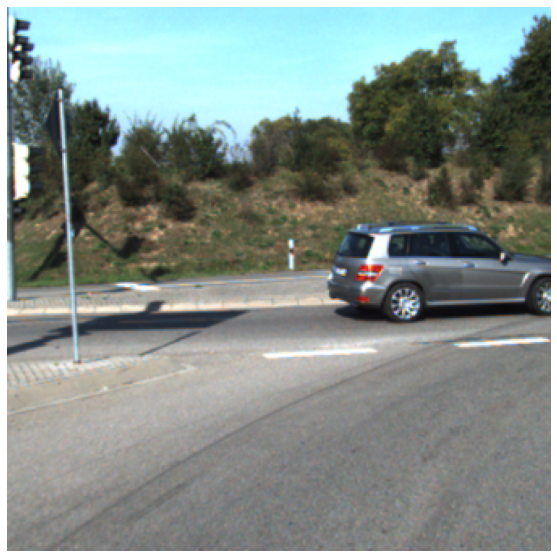

In [18]:
mt = learn.model.my_tuple[-2].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image(mt),figsize=(10,10))
# # print(mn)

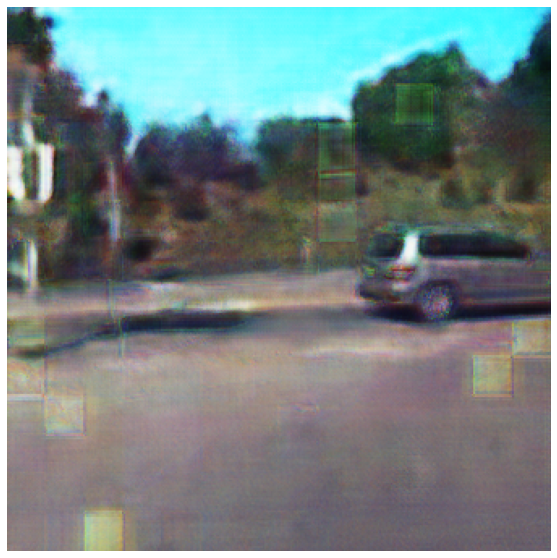

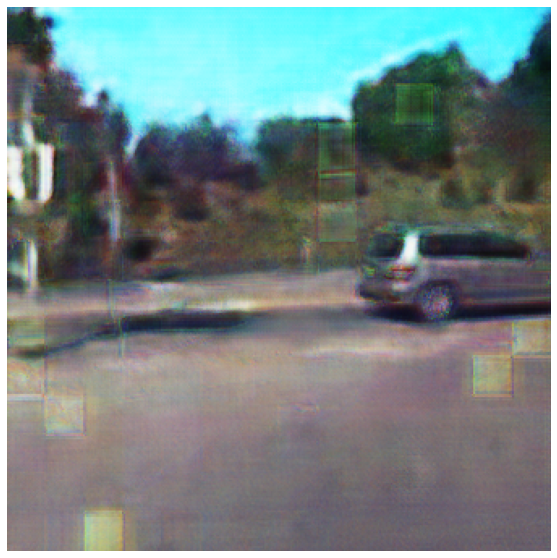

In [20]:

# # show_image(Image(learn.model.my_tuple[0][:,:50,:50]/255))
# # Image(learn.model.my_tuple[2].squeeze_().detach()/255.0)
for element in  learn.model.my_tuple:
    try:
                pass
    mt = learn.model.my_tuple[2].squeeze_().detach()
    mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image(mt),figsize=(10,10))

        
    except Exception:
mt = learn.model.my_tuple[2].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image(mt),figsize=(10,10))
# # print(mn)

# torch.min(learn.model.my_tuple[2].squeeze_().detach())

In [ ]:
aaa = (mt - mn)/(diff)

flip_lr(Image(aaa.cpu()))

In [ ]:
# learn.model.true_tuple_loss_false_just_out = False

# learn.show_results(figsize=(30,30))

In [ ]:
learn.model.my_tuple[-2].data